## Passion Fruits, Object detection and localization model

In [1]:
import cv2
import ast

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")
import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


### Read the csv files

### Train

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Data/PassionFruit/Train.csv')
train_df.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [5]:
train_df.shape

(3906, 6)

In [6]:
No_duplicates = train_df.drop_duplicates(subset="Image_ID")
print(No_duplicates.shape)

(3001, 6)


We have 3906 bounding boxes, from a collection of 3001 images. Some images have 1 bounding box, while others have more than 1 bounding box.

### Test

In [7]:
test_df = pd.read_csv("/content/drive/MyDrive/Data/PassionFruit/Test.csv")
test_df.head()

,Image_ID
0,ID_IUJJG62B
1,ID_ZPNDRD4T
2,ID_AHFYB64P
3,ID_L8JZLNTF
4,ID_IFMUXGPL


In [8]:
test_df.shape

(931, 1)

In [9]:
# train_df['xmax'] = train_df['xmin']+train_df1['width']
# train_df['ymax'] = train_df['ymin']+train_df['height']

In [10]:
# test_df = test_df.loc[:2]

- Encode the classes from str to int

In [11]:
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [12]:
train_df.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,3,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,1,97.5,17.5,245.0,354.5
2,ID_00WROUT9,1,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,2,125.0,193.0,254.5,217.0
4,ID_018UIENR,1,79.5,232.5,233.5,182.0


In [13]:
xmax = train_df['xmin']+train_df['width']
# train_df['ymax'] = train_df['ymin']+train_df['height']
train_df.insert(4, column='xmax', value=xmax)

In [14]:
ymax = train_df['ymin']+train_df['height']
# train_df['ymax'] = train_df['ymin']+train_df['height']
train_df.insert(5, column='ymax', value=ymax)

In [15]:
# train_df = train_df.loc[:20]
train_df.head()

,Image_ID,class,xmin,ymin,xmax,ymax,width,height
0,ID_007FAIEI,3,87.0,87.5,315.0,398.5,228.0,311.0
1,ID_00G8K1V3,1,97.5,17.5,342.5,372.0,245.0,354.5
2,ID_00WROUT9,1,156.5,209.5,404.5,512.0,248.0,302.5
3,ID_00ZJEEK3,2,125.0,193.0,379.5,410.0,254.5,217.0
4,ID_018UIENR,1,79.5,232.5,313.0,414.5,233.5,182.0


In [16]:
# train_df['xmin'] = train_df['xmin'].astype(np.float)
# train_df['ymin'] = train_df['ymin'].astype(np.float)
# train_df['width'] = train_df['width'].astype(np.float)
# train_df['height'] = train_df['height'].astype(np.float)
# train_df['xmax'] = train_df['xmax'].astype(np.float)
# train_df['ymax'] = train_df['ymax'].astype(np.float)

In [17]:
train_df.dtypes


Image_ID     object
class         int64
xmin        float64
ymin        float64
xmax        float64
ymax        float64
width       float64
height      float64
dtype: object

In [18]:
#@title Default title text
df = train_df.copy() # create a copy of the train df

In [19]:
path = '/content/drive/MyDrive/Data/PassionFruit/Train_Images/Train_Images/'
path2 = '/content/drive/MyDrive/Data/PassionFruit/Test_Images/Test_Images/'

In [20]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['Image_ID'])

In [21]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

   xmin  ymin   xmax   ymax
0  87.0  87.5  315.0  398.5


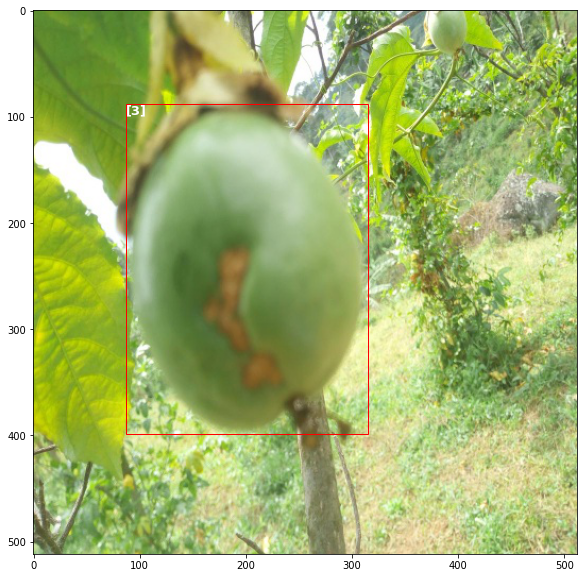

In [22]:
name = df.Image_ID.unique()[0]
plot_image(name)

      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5
      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5


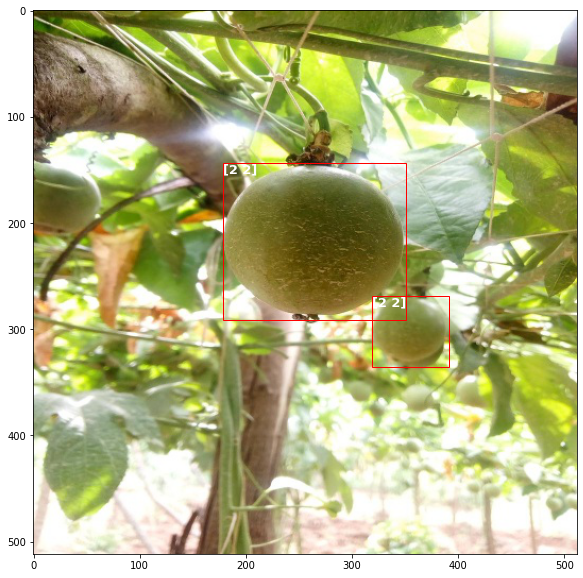

In [23]:
name = df.Image_ID.unique()[700]
# name = df.Image_ID.unique()[9]
plot_image(name)

    xmin  ymin   xmax   ymax
8  168.0  95.5  508.0  298.0


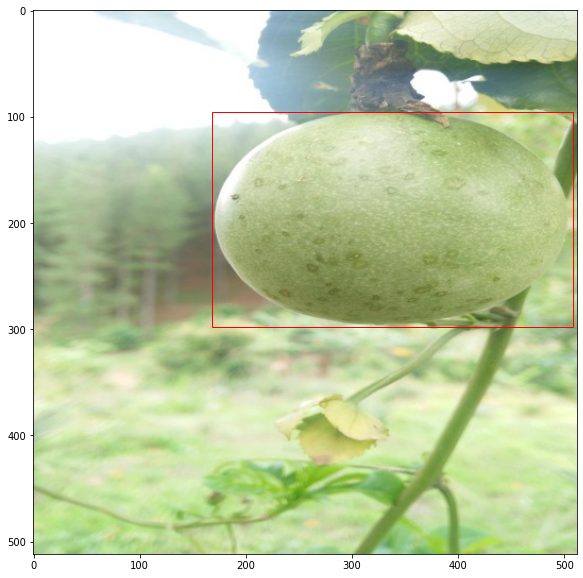

In [24]:
name = df.Image_ID.unique()[7]
plot_image(name)

In [25]:
class PassionFruit(object):
    def __init__(self, df, IMG_DIR, transforms=None): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['Image_ID'].unique()
        self.transforms = transforms
        
  
        self.classes = ["fruit_brownspot", "fruit_healthy", "fruit_woodiness"]
        # if self.classes[0] != "background":
        #     self.classes = ["background"] + self.classes
        # self.label_map = {c: i for i, c in enumerate(self.classes)}
        # self.lst = list(self.label_map.values())
        #self.label_map['background'] = 0
      
    def get_classes(self):
        return self.classes

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['Image_ID'] == image_id]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        #img_path = os.parth.join()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].values
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        labels = image_values["class"].values # 
        labels = labels - 1
        labels = torch.tensor(labels)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(image_values.shape[0], dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

In [26]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 7.7 MB/s 
     |████████████████████████████████| 948 kB 42.9 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=8d96bf172a096d8e63cca585a85f405c21d97af02ed1d1a8be5fe8d99fa52952
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [27]:
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"
# import albumentations
# from albumentations.pytorch.transforms import ToTensorV2
# import albumentations as A
# !pip install torch
# !pip install torchvision
# !apt install -y albumentations 
# !pip install -qU albumentations

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        #A.Resize(256, 256),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        #A.Resize(256, 256),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [28]:
import torchvision.transforms as T
def get_transforms(train):
  transforms = []
  transforms.append(T.ToTensor())
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [29]:
image_ids = df['Image_ID'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = df[df['Image_ID'].isin(valid_ids)]
train_df = df[df['Image_ID'].isin(train_ids)]
train_df.shape,valid_df.shape

((3054, 8), (852, 8))

In [30]:

train_dataset = PassionFruit(train_df, path, get_train_transform())
valid_dataset = PassionFruit(valid_df, path, get_valid_transform())


In [31]:
image, target = train_dataset.__getitem__(0)
print(image.shape)
print(target['boxes'])
print(target['labels'])

torch.Size([3, 512, 512])
tensor([[ 87.0000, 113.5000, 315.0000, 424.5000]], dtype=torch.float64)
tensor([2])


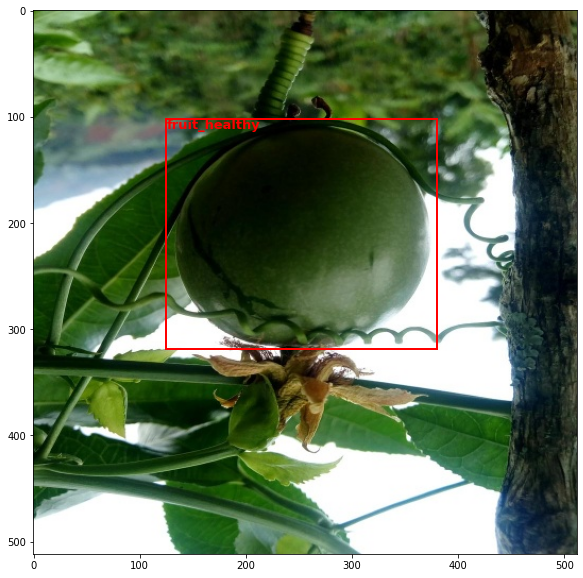

In [32]:
img, tar = train_dataset[random.randint(0,10)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {0:"fruit_brownspot",  1:"fruit_healthy", 2:"fruit_woodiness"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

#### Plotting the bounding boxes using the dataframe

In [33]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

In [35]:
def get_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [36]:
!git clone https://github.com/pytorch/vision.git
!cd vision && git checkout v0.3.0
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 59844, done.
remote: Counting objects: 100% (25313/25313), done.
remote: Compressing objects: 100% (3952/3952), done.
remote: Total 59844 (delta 21721), reused 24399 (delta 21134), pack-reused 34531
Receiving objects: 100% (59844/59844), 114.44 MiB | 31.00 MiB/s, done.
Resolving deltas: 100% (48269/48269), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [37]:
from engine import train_one_epoch, evaluate
from utils import *

def do_training(model, torch_dataset, torch_dataset_test, num_epochs=4):
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=4, shuffle=True, num_workers=4,
        collate_fn=collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=4, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    #device = torch.device("cpu")
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)



In [38]:
classes = ["fruit_brownspot", "fruit_healthy", "fruit_woodiness"]
model = get_model(len(classes)+ 1)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [39]:
# do_training(model, train_dataset, valid_dataset, num_epochs=15)

In [40]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/Data/PassionFruit/passion_fruit_model.pt')
# from google.colab import files
# files.download('passion_fruit_model.pt')

In [41]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Data/passion_fruit_model_V2.pt', map_location=torch.device('cpu')))


<All keys matched successfully>

In [42]:
from torchvision.transforms import functional as FF

class TestPassionFruit(object):
    def __init__(self, df, IMG_DIR,transforms=None): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['Image_ID'].unique()
        self.transforms = transforms
        
  
        self.classes = ["fruit_brownspot", "fruit_healthy", "fruit_woodiness"]
        # if self.classes[0] != "background":
        #     self.classes = ["background"] + self.classes
        # self.label_map = {c: i for i, c in enumerate(self.classes)}
        # self.lst = list(label_map.values())
        #self.label_map['background'] = 0
      
    def get_classes(self):
        return self.classes

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
     
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['Image_ID'] == image_id]
        image =  cv2.imread(self.img_dir+image_id+".jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        

        if self.transforms:
            sample = {
                'image': image
            }
        
            sample = self.transforms(sample)
            image = sample['image']

        return FF.to_tensor(image), image_id

In [58]:
test_dataset = TestPassionFruit(test_df, path2)


In [84]:
from torchvision import transforms

def apply_nms(orig, iou_thresh=0.6):
  keep = torchvision.ops.nms(orig[0]['boxes'], orig[0]['scores'], iou_thresh)
  final = orig[0]
  final['boxes'] = final['boxes'][keep]
  final['scores'] = final['scores'][keep]
  final['labels'] = final['labels'][keep]

  return final

def torch_to_pil(img):
  return transforms.ToPILImage()(img).convert('RGB')

In [107]:
img = test_dataset[7]
print(img[1])
model.eval()
with torch.no_grad():
    prediction = model([img[0]])


ID_PK02G2O5


In [108]:
prediction

[{'boxes': tensor([[282.4109, 215.9459, 418.3479, 381.2855],
          [213.5216, 219.8549, 303.1438, 351.3330],
          [ 69.5272, 330.1144, 205.1359, 512.0000],
          [222.9446, 217.0876, 349.3946, 374.2193],
          [454.9962, 467.3443, 510.1336, 510.7504]]),
  'labels': tensor([2, 2, 2, 2, 2]),
  'scores': tensor([0.9985, 0.9824, 0.9716, 0.3441, 0.0831])}]

In [109]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

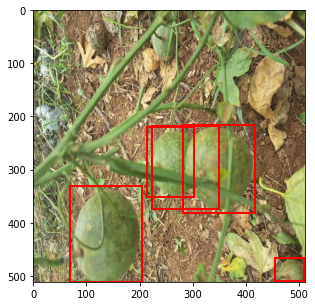

In [110]:
plot_img_bbox(torch_to_pil(img[0]), prediction[0])

In [113]:
ypred = apply_nms(prediction, 0.40)
ypred

{'boxes': tensor([[282.4109, 215.9459, 418.3479, 381.2855],
         [213.5216, 219.8549, 303.1438, 351.3330],
         [ 69.5272, 330.1144, 205.1359, 512.0000],
         [454.9962, 467.3443, 510.1336, 510.7504]]),
 'labels': tensor([2, 2, 2, 2]),
 'scores': tensor([0.9985, 0.9824, 0.9716, 0.0831])}

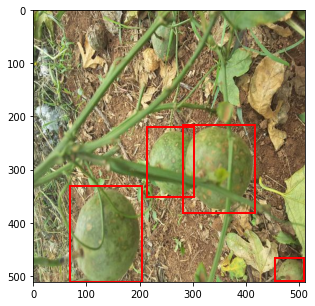

In [114]:
import matplotlib.patches as patches
plot_img_bbox(torch_to_pil(img[0]), ypred)

In [50]:
# hash = pd.DataFrame(columns = ['Image_ID','class','confidence',	'ymin',	'xmin',	'ymax',	'xmax'])
# classes_laudu = {1:"fruit_brownspot" , 2:"fruit_healthy",3:"fruit_woodiness"}

In [51]:

# for img in test_dataset:
#   image_id = img[1]
#   model.eval()
#   with torch.no_grad():
#     prediction = model([img[0]])
#     prediction = [apply_nms(prediction, 0.50)]
#     print(prediction)
#     plot_img_bbox(torch_to_pil(img), prediction)
    

#     if len(prediction[0]['boxes'])==0:
#         boxes = [0,0,0,0]
#     else:
#       boxes = prediction[0]['boxes'][0]
#     if len(prediction[0]['labels']) == 0:
#       classs = ['fruit_brownspot']
#     else:
#       classs = prediction[0]['labels'][0]
#       classs = classes_laudu[int(classs)]

#     if len(prediction[0]['scores']) == 0:
#       confidence = 0.0
#     else:
#       confidence = float(prediction[0]['scores'][0])
#     row = [image_id, classs, confidence, float(boxes[0]), float(boxes[1]), float(boxes[2]), float(boxes[3])]
#     hash.loc[len(hash),:] = row







In [52]:
+hash.to_csv('/content/drive/MyDrive/Data/PassionFruit/submission_2.csv')

AttributeError: ignored